In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd 
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import * 
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import random
import os 

2023-05-08 11:08:43.257312: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
data = {"id": list(range(1, 1183)), "label": [0]*1182}
df = pd.DataFrame(data)

# csv 파일로 저장
df.to_csv("/Users/inkyung/Desktop/IT_Projects/ttproject/ik_test/sample.csv", index=False)

In [7]:
# 폴더 경로 설정
path1 = "/Users/inkyung/Desktop/IT_Projects/ttproject/선정적 이미지 소스/노출 이미지"
path2 = "/Users/inkyung/Desktop/IT_Projects/ttproject/선정적 이미지 소스/비노출 이미지"

# 데이터 형상 관련 상수 정의 
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNEL = 3

# 데이터 준비 
filenames1 = os.listdir(path1)
filenames2 = os.listdir(path2)

categories1 = [1]*len(filenames1)  # True(노출)
categories2 = [0]*len(filenames2)  # False(비노출)

df1 = pd.DataFrame({
    "filename": filenames1,
    "category": categories1
})

df2 = pd.DataFrame({
    "filename": filenames2,
    "category": categories2
})

df = pd.concat([df1, df2], ignore_index=True)

df
# 노출이미지=1, 비노출이미지=0 으로 정답 레이블 생성

,filename,category
0,노출이미지021.JPG,1
1,노출이미지035.jpg,1
2,노출이미지009.jpg,1
3,노출이미지223.jpg,1
4,노출이미지237.jpg,1
...,...,...
1177,비노출이미지371.jpg,0
1178,비노출이미지417.jpg,0
1179,비노출이미지403.jpg,0
1180,비노출이미지365.jpg,0


<IPython.core.display.Javascript object>


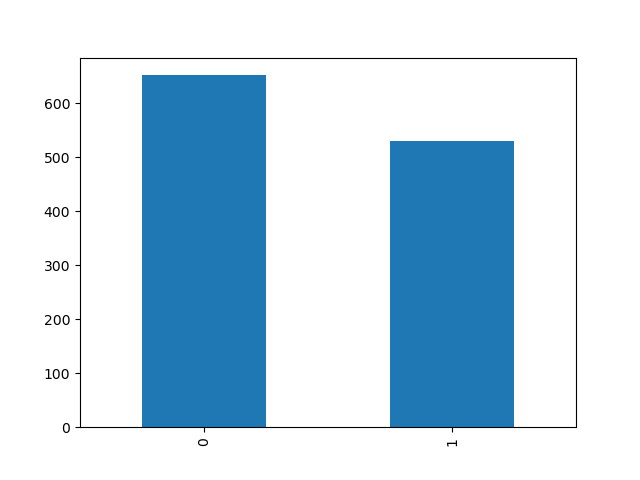

<AxesSubplot:>

In [8]:
%matplotlib notebook
df['category'].value_counts().plot.bar()

<IPython.core.display.Javascript object>


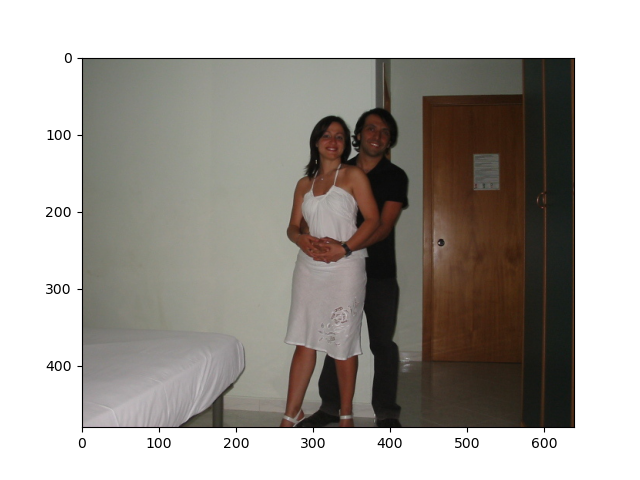

In [14]:
%matplotlib notebook
from tensorflow.keras.preprocessing.image import load_img

path_combined = os.path.join(path1, path2)
filenames = os.listdir(path_combined)

sample = random.choice(filenames)
img_path = os.path.join(path_combined, sample)
image = load_img(img_path)
plt.imshow(image)

In [15]:
# 모델 생성

from keras.models import Sequential
from keras.layers import * 

In [16]:
# 레이어 1
model = Sequential()
model.add(Conv2D(32, (3,3), activation="relu", input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH , IMAGE_CHANNEL)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 레이어 2 
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 레이어3
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
          
# Fully Connected 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2,activation="softmax"))

In [17]:
# 모델 실행 옵션 
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [18]:
# reduceLROnPlateau 
# : callback 함수의 일종, learning rate가 더이상 업데이트가 되지 않으면, 학습을 중단하여라 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_accuracy", 
                        patience = 2, 
                        factor = 0.5, 
                        min_lr=0.0001,
                        verbose=1)
                        
callbacks = [earlystop, learning_rate_reduction]

In [19]:
# 이미지 제너레이터에서 class_mode = "categorical"로 지정하기 위해 컬럼 카테고리를 스트링으로 변경함. 
df['category']=df['category'].replace({0:'비노출',1:"노출"})

In [20]:
# test, train 데이터 분리

train_df, validate_df = train_test_split(df , test_size=0.2, random_state= 42)

train_df=train_df.reset_index(drop=True)
validate_df=validate_df.reset_index(drop=True)

In [21]:
train_df['category'].value_counts()

비노출    522
노출     423
Name: category, dtype: int64

In [22]:
validate_df['category'].value_counts()

비노출    130
노출     107
Name: category, dtype: int64

In [48]:
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=10

# 트레이닝 데이터의 제너레이터 설정 
train_datagen=ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1, 
        height_shift_range=0.1,
        )

train_generator=train_datagen.flow_from_dataframe(
    train_df, 
    path_combined,
    x_col = "filename", 
    y_col = "category",
    target_size = IMAGE_SIZE,
    class_mode = "categorical",
    batch_size = batch_size,
    shuffle = True)
    
validate_datagen=ImageDataGenerator(rescale=1./255)
# 검증이미지니까, 사진 그대로 쓰겠다. 

validation_generator=validate_datagen.flow_from_dataframe(
    validate_df,
    path_combined,
    x_col= "filename",
    y_col= "category",
    target_size = IMAGE_SIZE,
    class_mode = "categorical",
    batch_size = batch_size,
    shuffle = True)

Found 522 validated image filenames belonging to 1 classes.
Found 130 validated image filenames belonging to 1 classes.


In [49]:
# 샘플 데이터 확인
example_df=train_df.sample(n=1).reset_index(drop=True)
example_df

,filename,category
0,비노출이미지275.jpg,비노출


In [50]:
example_generator = train_datagen.flow_from_dataframe(
                    example_df,
                    path_combined,
                    x_col = "filename",
                    y_col = "category",
                    target_size = IMAGE_SIZE,
                    class_mode = "categorical")

Found 1 validated image filenames belonging to 1 classes.


<IPython.core.display.Javascript object>


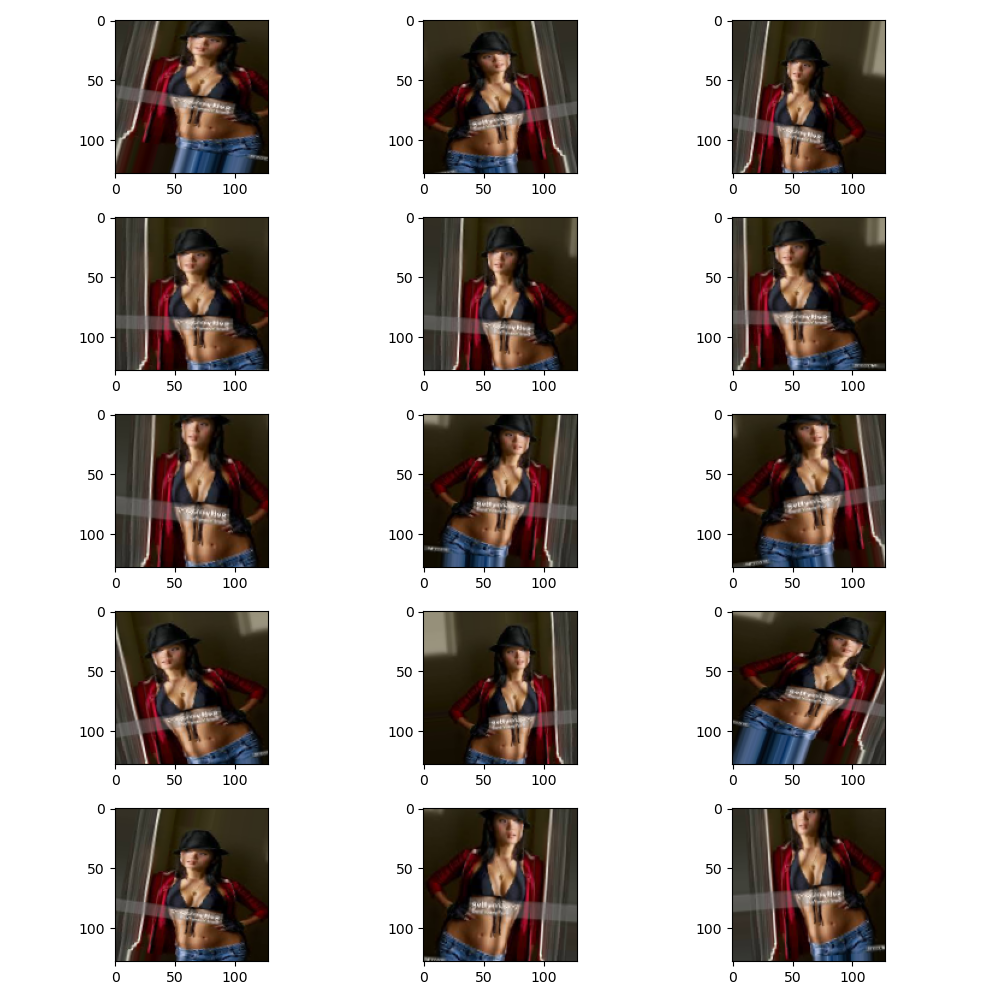

In [51]:
plt.figure(figsize=(10,10))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    for xBatch, yBatch in example_generator:
        image = xBatch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [33]:
# 트레이닝

epochs = 3

history = model.fit_generator(
    train_generator, 
    epochs = epochs, 
    steps_per_epoch = total_train//batch_size ,
    validation_data=  validation_generator,
    validation_steps = total_validate//batch_size,
    callbacks = callbacks,
)

# 모델 저장 
model.save_weights("model.h5")


## -> 데이터셋이 충분한 배치 생성 못함 -> shuffle=True로 변경

/var/folders/2x/pptt888d2_x9jxvslsglvm0w0000gn/T/ipykernel_30657/8788327.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/3


2023-05-08 11:31:08.289760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/63 [===============>..............] - ETA: 23s - loss: 2.1004 - accuracy: 0.4540WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 189 batches). You may need to use the repeat() function when building your dataset.


2023-05-08 11:31:38.181742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


63/63 [==============================] - 33s 508ms/step - loss: 2.1004 - accuracy: 0.4540 - val_loss: 1.6718 - val_accuracy: 0.9615 - lr: 0.0010


In [52]:
# 트레이닝

epochs = 3

history = model.fit_generator(
    train_generator, 
    epochs = epochs, 
    steps_per_epoch = total_train // batch_size,
    validation_data=  validation_generator,
    validation_steps = total_validate//batch_size,
    callbacks = callbacks,
)

# 모델 저장 
model.save_weights("model.h5")

## 그래도 안돼서 batch_size 10으로 낮춰봄 -> 그래도 안되는군,,, 데이터 증강 필요...

Epoch 1/3


/var/folders/2x/pptt888d2_x9jxvslsglvm0w0000gn/T/ipykernel_30657/2309911835.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2023-05-08 11:52:57.526248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


53/94 [===============>..............] - ETA: 26s - loss: 1.9216 - accuracy: 0.4923WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 282 batches). You may need to use the repeat() function when building your dataset.


2023-05-08 11:53:32.370634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


94/94 [==============================] - 38s 398ms/step - loss: 1.9216 - accuracy: 0.4923 - val_loss: 1.3905 - val_accuracy: 0.6615 - lr: 0.0010


<IPython.core.display.Javascript object>


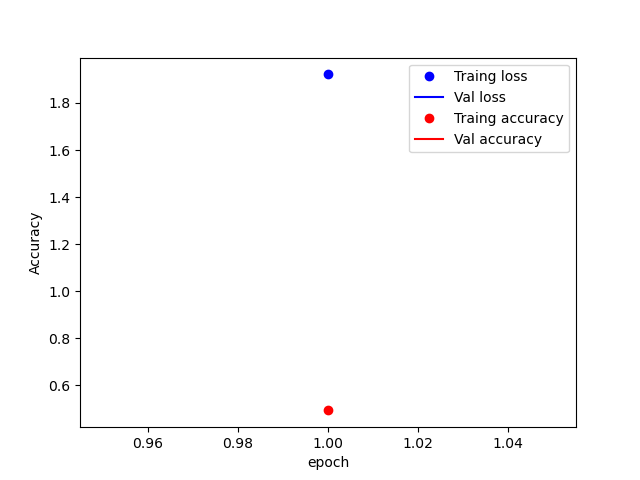

In [56]:
# 트레이닝 모델 히스토리 시각화 

historyDict=history.history

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

%matplotlib notebook
epo = range(1, len(acc)+1)
plt.plot(epo, loss, 'bo', label="Traing loss")
plt.plot(epo, val_loss, 'b', label="Val loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [57]:
plt.plot(epo, acc, 'ro', label="Traing accuracy")
plt.plot(epo, val_acc, 'r', label="Val accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [87]:
# 테스트 데이터 준비 
path1 = "/Users/inkyung/Desktop/IT_Projects/ttproject/선정적 이미지 소스/노출 이미지"
path2 = "/Users/inkyung/Desktop/IT_Projects/ttproject/선정적 이미지 소스/비노출 이미지"
#path_combined = os.path.join(path1, path2)
path_list = [path1, path2]

filenames = []
for path in path_list:
    filenames += os.listdir(path)

test_df=pd.DataFrame({"filename": filenames})
test_df

,filename
0,노출이미지021.JPG
1,노출이미지035.jpg
2,노출이미지009.jpg
3,노출이미지223.jpg
4,노출이미지237.jpg
...,...
1177,비노출이미지371.jpg
1178,비노출이미지417.jpg
1179,비노출이미지403.jpg
1180,비노출이미지365.jpg


In [88]:
nbsamples=test_df.shape[0]
nbsamples

1182

In [94]:
# 모든 이미지 파일 가져오기
filenames = []
for path in [path1, path2]:
    for file in os.listdir(path):
        if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
            filenames.append(os.path.join(path, file))

In [95]:
# 테스트 데이터 생성
test_df = pd.DataFrame({"filename": filenames})
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col=None,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=15,
    shuffle=False
)

Found 1143 validated image filenames.


In [96]:
# 예측 
predict=model.predict_generator(test_generator, 
                                steps=nbsamples/batch_size, 
                                callbacks=callbacks)
                                
test_df['category']=np.argmax(predict, axis=1)


/var/folders/2x/pptt888d2_x9jxvslsglvm0w0000gn/T/ipykernel_30657/2396258052.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict=model.predict_generator(test_generator,


OSError: image file is truncated (10 bytes not processed)